In [1]:
# ── Imports ───────────────────────────────────────────────────
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from src.preprocessing import load_data
from src.forecasting_sim import crash_probability
from src.forecasting_sample import sample_crash_probability
from src.closed_form import cauchy_predictive_density, make_grid

# ── Load data ─────────────────────────────────────────────────
params, series = load_data()

print(f"Data period: {series.index[0].strftime('%Y-%m')} to {series.index[-1].strftime('%Y-%m')}")
print(f"Total observations: {len(series)}")
print(f"Model: MAR({params.r},{params.s})")
print(f"Parameters: φ={params.phi:.3f}, ψ={params.psi:.3f}, df={params.df:.2f}, σ={params.scale:.1f}")

Parameters : MAR(1,1) | φ=0.617062379728722, ψ=0.777070127450962, df=1.4947, σ=402.94
Series     : 475 obs [1980-02 → 2019-08]
Data period: 1980-02 to 2019-08
Total observations: 475
Model: MAR(1,1)
Parameters: φ=0.617, ψ=0.777, df=1.49, σ=402.9


The paper identifies six forecast points along the 2007 Nickel bubble trajectory (Table 3, Figure 9) but does not provide exact calendar dates. The points are defined by their quantile positions in the empirical distribution:

- **Point 1** (Q=0.376): Early buildup phase
- **Point 2** (Q=0.951): Accelerating bubble  
- **Point 3** (Q=0.985): Peak (May 2007, explicitly stated in text)
- **Point 4** (Q=0.989): Post-crash observation
- **Point 5** (Q=0.993): Recovery attempt
- **Point 6** (Q=0.949): Stabilization after crash inclusion

We identify approximate calendar dates by visual inspection of Figure 9 and alignment with the stated peak in May 2007. Small differences from the paper's exact points are expected and do not affect the qualitative conclusions.

In [20]:
# ── Define six forecast points (Table 3 from paper) ───────────
forecast_points = pd.DataFrame({
    'Date': pd.to_datetime([
        '2006-05-01',  # Point 1: Early buildup
        '2006-09-01',  # Point 2: Mid-buildup
        '2007-02-01',  # Point 3: Late buildup
        '2007-03-01',  # Point 4: Just before peak
        '2007-05-01',  # Point 5: Peak (May 2007)
        '2011-02-01',  # Point 6: Later peak around 2011
    ]),
    'Label': ['Point 1', 'Point 2', 'Point 3', 'Point 4', 'Point 5', 'Point 6']
})

# Extract cycle and u_t values at these points
forecast_points['cycle'] = [
    float(series.loc[date, 'cycle']) for date in forecast_points['Date']
]
forecast_points['u_t'] = [
    float(series.loc[date, 'u_t']) for date in forecast_points['Date']
]

# Calculate empirical quantiles for our chosen points
forecast_points['Quantile'] = [
    (series['cycle'] < row['cycle']).mean() 
    for _, row in forecast_points.iterrows()
]

print("\nForecast Points with Quantiles:")
print(forecast_points[['Label', 'Date', 'cycle', 'Quantile']].to_string(index=False))


Forecast Points with Quantiles:
  Label       Date        cycle  Quantile
Point 1 2006-05-01  -430.159027  0.480000
Point 2 2006-09-01  7712.280604  0.964211
Point 3 2007-02-01 17916.989864  0.989474
Point 4 2007-03-01 22932.780917  0.993684
Point 5 2007-05-01 28585.358045  0.997895
Point 6 2011-02-01  7856.883200  0.966316


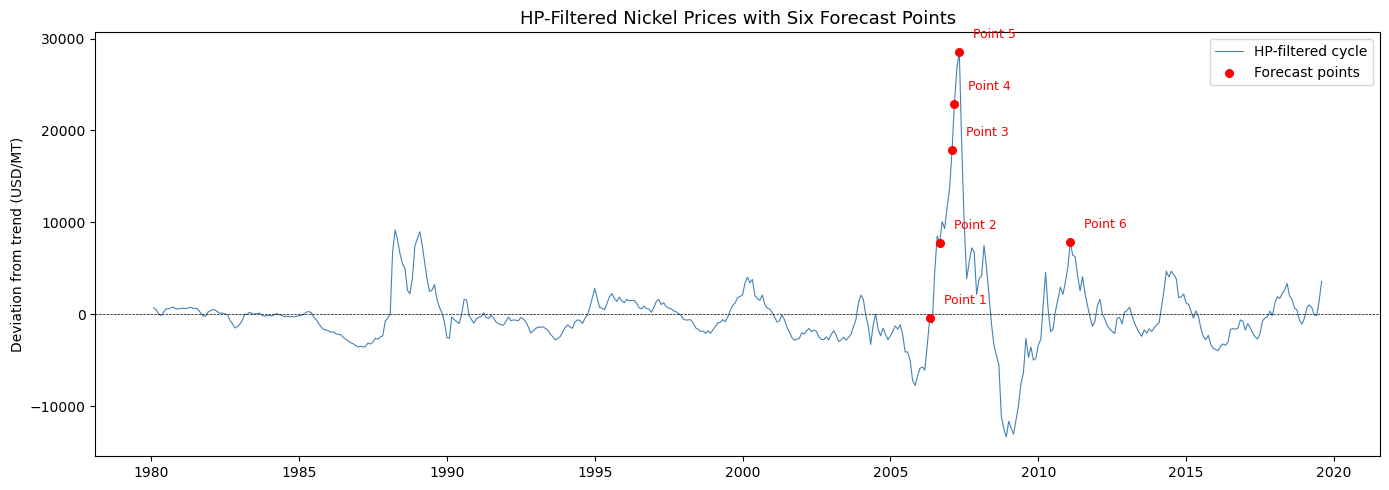

In [22]:
# ── Cell 3: Figure 9 — Forecast points on HP-filtered cycle ──
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(series.index, series['cycle'], 
        color='steelblue', linewidth=0.8, label='HP-filtered cycle')
ax.scatter(forecast_points['Date'], forecast_points['cycle'],
           color='red', s=30, marker='o', zorder=5, label='Forecast points')

# Label each point
for _, row in forecast_points.iterrows():
    ax.annotate(row['Label'], 
                xy=(row['Date'], row['cycle']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, color='red')

ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('HP-Filtered Nickel Prices with Six Forecast Points', fontsize=13)
ax.set_ylabel('Deviation from trend (USD/MT)')
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/figures/09_forecast_points.png', dpi=150)
plt.show()

In [23]:
# ── Cell 4: Compute crash probabilities (Table 3) ─────────────
thresholds = {
    'Any decrease': 1.0,      # P(y*_{T+1} < y_T)
    '20% crash': 0.80,        # P(y*_{T+1} < 0.8·y_T)
    '40% crash': 0.60,        # P(y*_{T+1} < 0.6·y_T)
}

results = []
for idx, point in forecast_points.iterrows():
    u_T = point['u_t']
    y_T = point['cycle']
    u_sample = series.loc[:point['Date'], 'u_t'].values
    
    for crash_name, factor in thresholds.items():
        threshold_u = factor * u_T
        
        # Method 1: Simulation-based
        prob_sim = crash_probability(
            u_T=u_T, psi=params.psi, df=params.df, scale=params.scale,
            threshold=threshold_u, N=100_000, M=100
        )
        
        # Method 2: Sample-based
        prob_sample = sample_crash_probability(
            u_T=u_T, u_sample=u_sample, psi=params.psi,
            df=params.df, scale=params.scale, threshold=threshold_u
        )
        
        results.append({
            'Point': point['Label'],
            'Date': point['Date'].strftime('%Y-%m'),
            'Quantile': point['Quantile'],
            'Crash': crash_name,
            'Sims': prob_sim,
            'Sample': prob_sample,
            'Diff': prob_sample - prob_sim,
        })
    
    print(f"{point['Label']} done")

results_df = pd.DataFrame(results)
print("\nTable 3: One-step ahead crash probabilities")
print(results_df.to_string(index=False))

Point 1 done
Point 2 done
Point 3 done
Point 4 done
Point 5 done
Point 6 done

Table 3: One-step ahead crash probabilities
  Point    Date  Quantile        Crash     Sims   Sample      Diff
Point 1 2006-05  0.480000 Any decrease 0.498534 0.490075 -0.008459
Point 1 2006-05  0.480000    20% crash 0.527538 0.506311 -0.021227
Point 1 2006-05  0.480000    40% crash 0.558012 0.522548 -0.035464
Point 2 2006-09  0.964211 Any decrease 0.428841 0.634541  0.205699
Point 2 2006-09  0.964211    20% crash 0.328913 0.514383  0.185470
Point 2 2006-09  0.964211    40% crash 0.252614 0.438406  0.185792
Point 3 2007-02  0.989474 Any decrease 0.353758 0.622708  0.268950
Point 3 2007-02  0.989474    20% crash 0.332535 0.589216  0.256681
Point 3 2007-02  0.989474    40% crash 0.300835 0.559187  0.258352
Point 4 2007-03  0.993684 Any decrease 0.336167 0.613925  0.277758
Point 4 2007-03  0.993684    20% crash 0.301051 0.588080  0.287029
Point 4 2007-03  0.993684    40% crash 0.325737 0.562771  0.237034
Point 

In [24]:
# ── Cell 5: Format Table 3 for thesis ─────────────────────────
table3_pivot = results_df.pivot_table(
    index=['Point', 'Date', 'Quantile'],
    columns='Crash',
    values=['Sims', 'Sample', 'Diff']
).round(3)

print("Table 3: One-step ahead crash probabilities (formatted)")
print(table3_pivot)

# Save to CSV
table3_pivot.to_csv('../outputs/tables/table3_crash_probabilities.csv')
print("\nSaved to outputs/tables/table3_crash_probabilities.csv")

Table 3: One-step ahead crash probabilities (formatted)
                              Diff                           Sample            \
Crash                    20% crash 40% crash Any decrease 20% crash 40% crash   
Point   Date    Quantile                                                        
Point 1 2006-05 0.480000    -0.021    -0.035       -0.008     0.506     0.523   
Point 2 2006-09 0.964211     0.185     0.186        0.206     0.514     0.438   
Point 3 2007-02 0.989474     0.257     0.258        0.269     0.589     0.559   
Point 4 2007-03 0.993684     0.287     0.237        0.278     0.588     0.563   
Point 5 2007-05 0.997895     0.286     0.236        0.282     0.586     0.551   
Point 6 2011-02 0.966316     0.083     0.083        0.087     0.405     0.334   

                                           Sims                         
Crash                    Any decrease 20% crash 40% crash Any decrease  
Point   Date    Quantile                                            

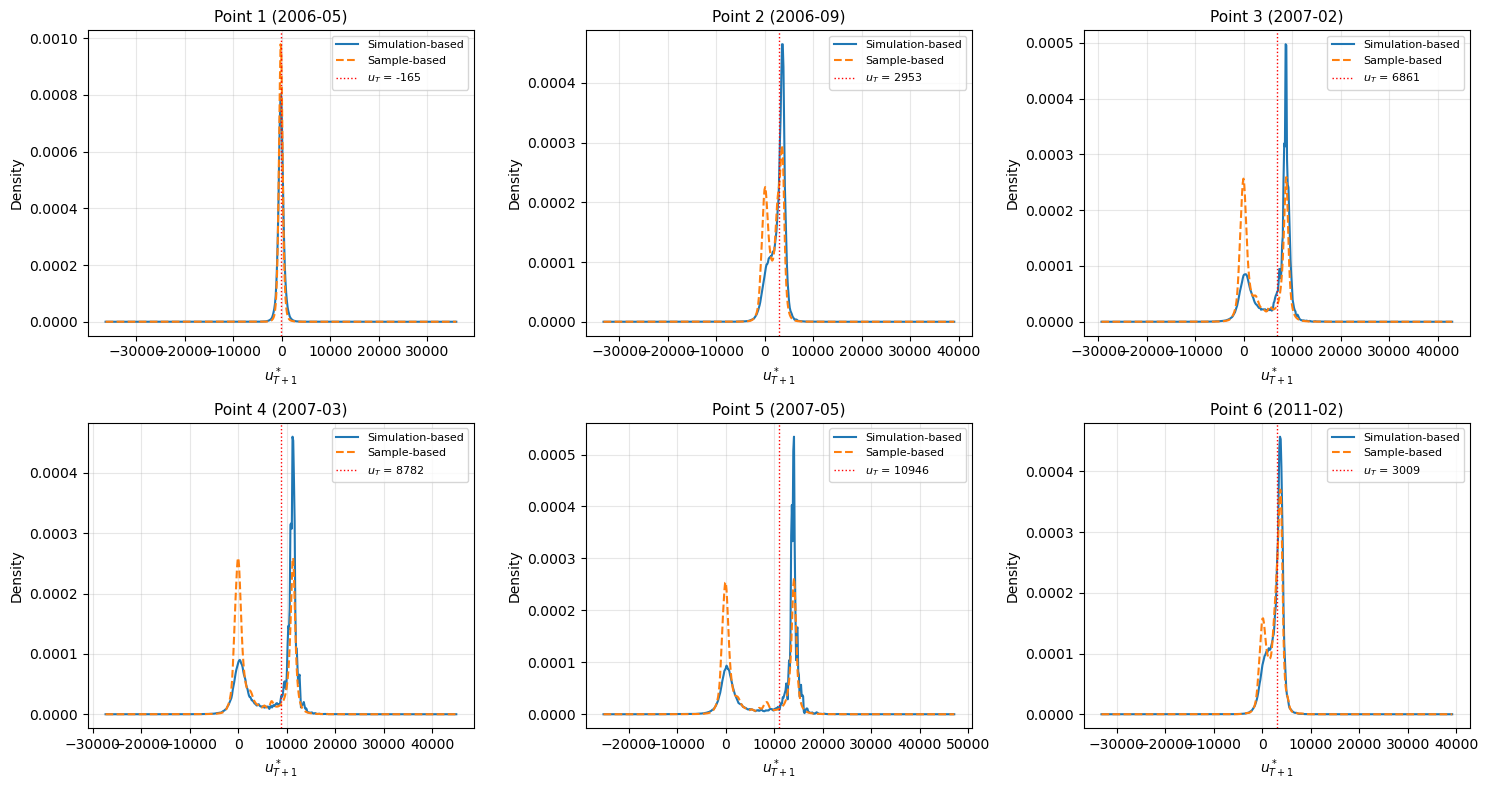

In [25]:
# ── Cell 6: Plot predictive densities at all six points ───────
from src.forecasting_sim import simulate_predictive_cdf

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, point in forecast_points.iterrows():
    ax = axes[idx]
    u_T = point['u_t']
    u_sample = series.loc[:point['Date'], 'u_t'].values
    
    # Build grid
    grid = make_grid(u_T, params.scale, params.psi, n_points=500)
    
    # Method 1: Simulation-based CDF
    cdf_sim = simulate_predictive_cdf(
        u_T, params.psi, params.df, params.scale, grid, N=50_000, M=100
    )
    density_sim = np.gradient(cdf_sim, grid)
    
    # Method 2: Sample-based density
    from src.forecasting_sample import sample_predictive_density
    density_sample = sample_predictive_density(
        u_T, u_sample, params.psi, params.df, params.scale, grid
    )
    
    # Plot both
    ax.plot(grid, density_sim, label='Simulation-based', linewidth=1.5)
    ax.plot(grid, density_sample, label='Sample-based', linewidth=1.5, linestyle='--')
    ax.axvline(u_T, color='red', linestyle=':', linewidth=1, label=f'$u_T$ = {u_T:.0f}')
    ax.set_title(f"{point['Label']} ({point['Date'].strftime('%Y-%m')})", fontsize=11)
    ax.set_xlabel('$u^*_{T+1}$')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/10_predictive_densities.png', dpi=150)
plt.show()